# Notes and disclaimer

This notebook has been used as a personal learning exercise to practice and play around with the Scikit-Learn library. The dataset used was the *House Price Prediction Seattle* from kaggle: https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle

As someone living in the Seattle area who is working towards homeownership and expanding my software engineering skills, I thought it would be interesting to find a dataset about prices in the area, analyze the data, and create a model to see how the model predictions compare to some of the prices from listings in Redfin

The contents, results, and predictions are purely academic

### Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestRegressor

### Load, analyze, and preparade data

The files have been downloaded from kaggle and added to the directory

In [2]:
TEST_PATH = 'test.csv'
TRAIN_PATH = 'train.csv'
current_directory = os.getcwd()

def load_housing_data():
    train_path = os.path.join(current_directory, TRAIN_PATH)
    test_path = os.path.join(current_directory, TEST_PATH)
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

In [3]:
housing_train, housing_test = load_housing_data()

In [4]:
housing_train.shape

(2016, 8)

In [5]:
housing_test.shape

(505, 8)

In [6]:
housing_train.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [7]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size        1669 non-null   float64
 5   lot_size_units  1669 non-null   object 
 6   zip_code        2016 non-null   int64  
 7   price           2016 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 126.1+ KB


In [8]:
housing_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            505 non-null    int64  
 1   baths           505 non-null    float64
 2   size            505 non-null    float64
 3   size_units      505 non-null    object 
 4   lot_size        428 non-null    float64
 5   lot_size_units  428 non-null    object 
 6   zip_code        505 non-null    int64  
 7   price           505 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 31.7+ KB


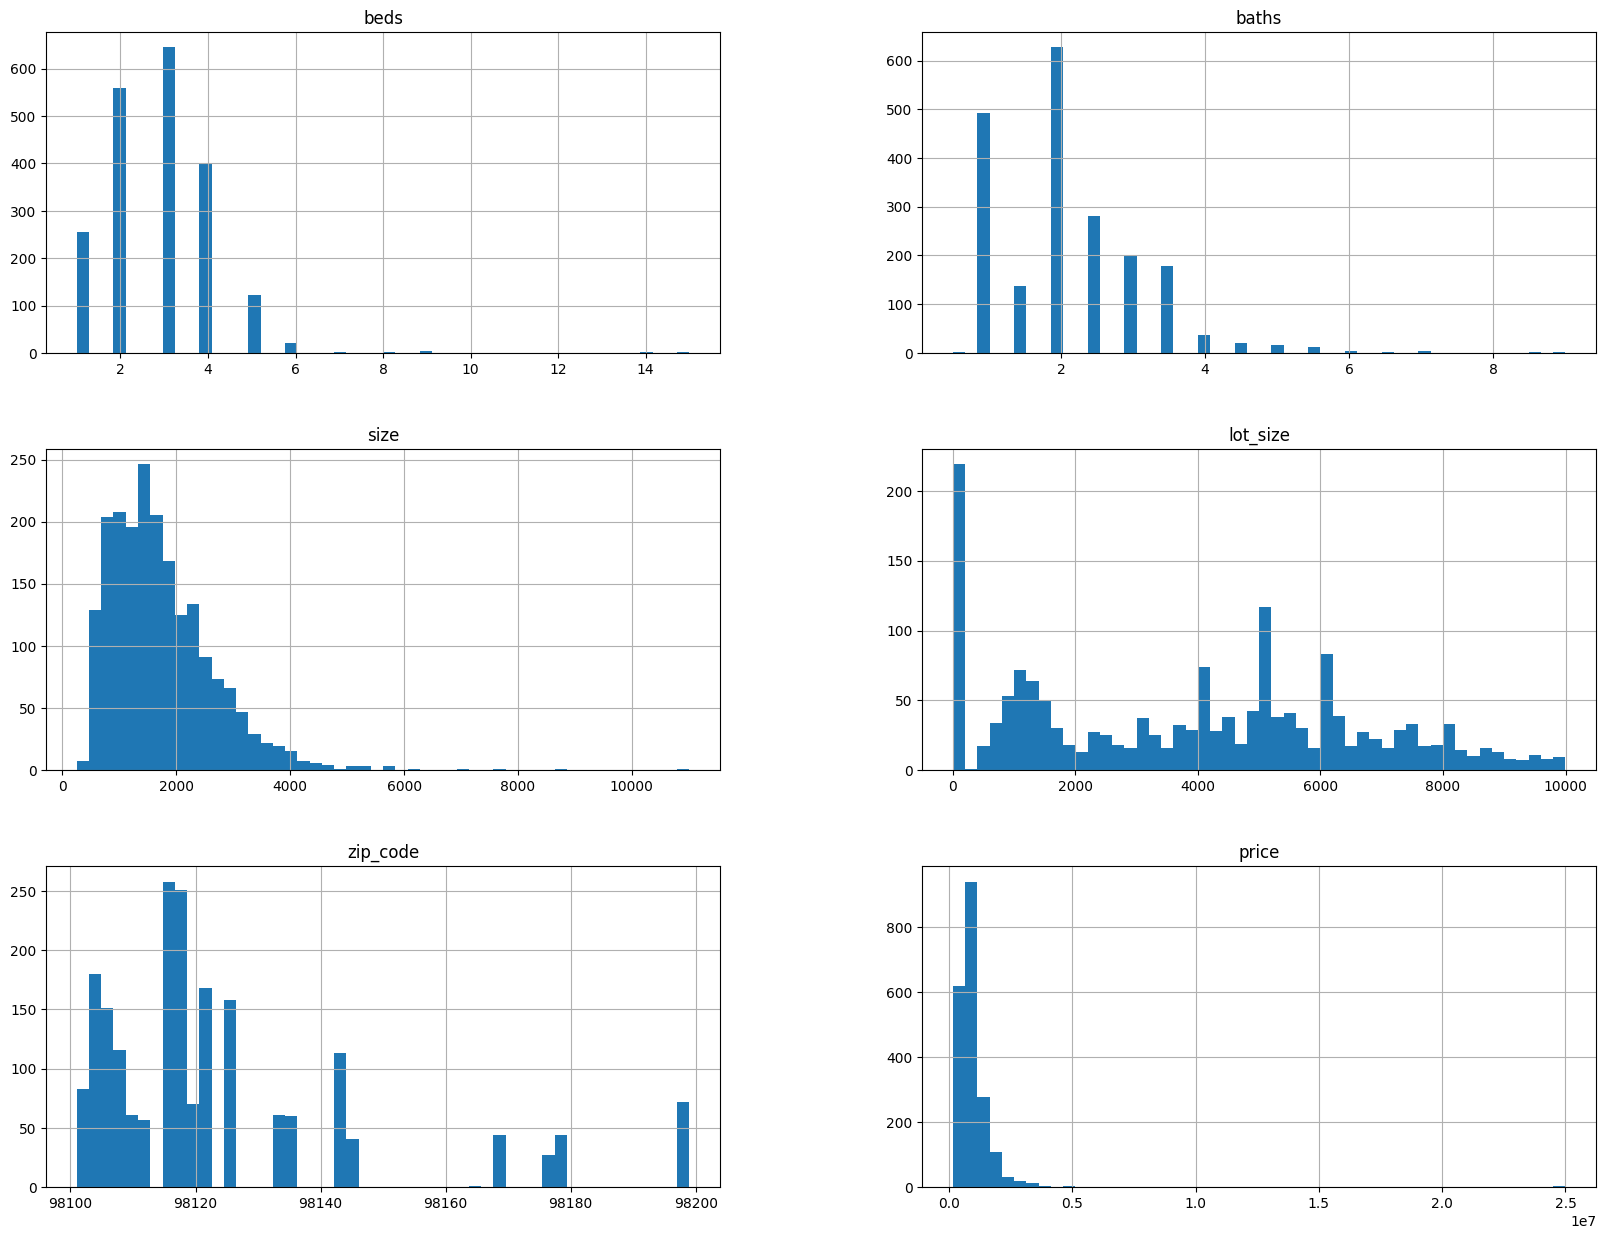

In [9]:
housing_train.hist(bins=50, figsize=(20,15))
plt.show()

There are few observations to be made:

1. Some lot sizes are in acres and some are in sqft
* We need to have them use the same metric
2. Some lot sizes have null data. We have some options:
* Remove all the entries will null data for lot sizes
* Fill with the average/mean/median
* Create a model to fill these values
3. The dataset is pretty small so the expectation of the model is to perform somewhat poorly


For this scenario, we will be formattig all entries to use sqft for their lot size. We will also fill the null lot sizes using a __SimplerImputer__. Since there are only around 2500 entries, dropping some will create a really small dataset so it is preferable to fill them instead of removing them.

Additionally, we will format the data to have a bigger training set. Currently, the test set is around 20%, we will change that to be 15% so there is more training data for our model to work with

In [10]:
housing_data = pd.concat([housing_train, housing_test], axis=0)
housing_data.shape

(2521, 8)

In [11]:
housing_data.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [12]:
acre_to_sqft_conversion = 43560

def convert_lot_size_to_sqft(data=housing_data):
    housing_data['lot_size'] = housing_data.apply(lambda row: row['lot_size'] * acre_to_sqft_conversion if row['lot_size_units'] == 'acre' else row['lot_size'], axis=1)
    housing_data['lot_size_units'] = housing_data['lot_size_units'].apply(lambda unit: 'sqft' if unit == 'acre' else unit)
    return housing_data

In [13]:
housing_data = convert_lot_size_to_sqft()
housing_data.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.0,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,13503.6,sqft,98106,915000.0
2,4,3.0,2040.0,sqft,3783.0,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.0,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [14]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2521 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2521 non-null   int64  
 1   baths           2521 non-null   float64
 2   size            2521 non-null   float64
 3   size_units      2521 non-null   object 
 4   lot_size        2097 non-null   float64
 5   lot_size_units  2097 non-null   object 
 6   zip_code        2521 non-null   int64  
 7   price           2521 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 177.3+ KB


In [15]:
housing_data['zip_code'].value_counts()

zip_code
98103    214
98115    209
98117    189
98122    138
98144    134
98118    120
98125    107
98126    102
98107    100
98116    100
98199     97
98106     93
98119     89
98105     88
98102     79
98136     77
98109     74
98121     73
98133     73
98112     69
98178     60
98146     56
98168     51
98108     46
98177     35
98101     28
98104     17
98164      2
98188      1
Name: count, dtype: int64

In [16]:
len(housing_data['zip_code'].value_counts())

29

Seattle has 30 zip codes and not all zip codes are well represented in this dataset. While the location of a house has definitely an impact on the price, we will be dropping it from the dataset as there is not enough information. With the current data, the model might use zip codes for price prediction in unexpected ways. The model, will be more generic in predicting prices for houses in Seattle rather than prices in an specific area of Seattle

In [17]:
columns_to_drop = ["size_units", "lot_size_units", "zip_code"] # drop object columns and zip code

housing_data = housing_data.drop(columns=columns_to_drop)
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2521 entries, 0 to 504
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      2521 non-null   int64  
 1   baths     2521 non-null   float64
 2   size      2521 non-null   float64
 3   lot_size  2097 non-null   float64
 4   price     2521 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 118.2 KB


In [18]:
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_data)

X = imputer.transform(housing_data)
housing_data = pd.DataFrame(X, columns=housing_data.columns, index=housing_data.index)
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2521 entries, 0 to 504
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      2521 non-null   float64
 1   baths     2521 non-null   float64
 2   size      2521 non-null   float64
 3   lot_size  2521 non-null   float64
 4   price     2521 non-null   float64
dtypes: float64(5)
memory usage: 118.2 KB


We have now dropped the object columns and filled the blank values with the median. We are now ready to split the data into train and test sets, separate the labels from the rest of the data, and train the model

In [19]:
def create_seattle_housing_train_test(data=housing_data, test_ratio=0.15):
    shuffled_indices = np.random.permutation(len(housing_data))
    test_size = int(len(housing_data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return housing_data.iloc[train_indices], housing_data.iloc[test_indices]

In [20]:
X_train, X_test = create_seattle_housing_train_test()

In [21]:
X_train.shape

(2143, 5)

In [22]:
X_test.shape

(378, 5)

In [23]:
y_train = X_train["price"].copy()
y_test = X_test["price"].copy()

X_train = X_train.drop("price", axis=1)
X_test = X_test.drop("price", axis=1)

In [24]:
X_train.head()

,beds,baths,size,lot_size
246,4.0,5.5,2867.0,4983.0
159,1.0,1.0,603.0,5000.0
1068,4.0,1.0,1600.0,11761.2
1236,3.0,1.0,1450.0,7200.0
1833,2.0,1.0,808.0,5000.0


In [25]:
y_train.head()

246     1750000.0
159      450000.0
1068     652000.0
1236    1125000.0
1833     422500.0
Name: price, dtype: float64

### Train model

We will first see the performance of a linear regression model

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

housing_predictions_lin = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, housing_predictions_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

638728.420317798

In [27]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

housing_predictions_for = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, housing_predictions_for)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

283225.15165648883

In [28]:
housing_data['price'].mean()

966821.676318921

The forest model performed a lot better than linear regression. Given that the average house price is *$966821.68* and the training data was just above 2000 instances, the model did not performed too badly - being off around 30% of the price, although larger data and more complex models will definitely reduce the error of the predictions

### Evaluation and testing

In [29]:
final_model = forest_reg
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1439223.7102841125

In [30]:
new_house = [[2, 1.5, 1300, 3000]] # 2 bed, 1.5 bathroom, 1300sqft, and 3000sqft lot

prediction = final_model.predict(new_house)
prediction[0]

/Users/lealal/Documents/Software/HousingSeattle/housingseattle/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


705439.96

The evaluation on the testing data was quite horrendous, but the predicted price for the test house is quite close to the actual prices in Seattle for a similar house